In [2]:
# MariaDB에서 정보 끌어오는 법
from Investar import Analyzer
mk = Analyzer.MarketDB()
df = mk.get_daily_price('삼성전자')
df

start_date is initialized to '2019-09-10'
end_date is initialized to "2020-09-09"


,code,date,open,high,low,close,diff,volume
date,,,,,,,,
2019-09-10,005930,2019-09-10,47100,47200,46550,47000,100,9231792
2019-09-11,005930,2019-09-11,47300,47400,46800,47150,150,16141619
2019-09-16,005930,2019-09-16,47000,47100,46400,47100,50,15550926
2019-09-17,005930,2019-09-17,47000,47100,46800,46900,200,7006280
2019-09-18,005930,2019-09-18,46900,47700,46800,47700,800,10413027
...,...,...,...,...,...,...,...,...
2020-09-01,005930,2020-09-01,54100,54800,54100,54200,200,19363117
2020-09-02,005930,2020-09-02,54600,55100,54100,54400,200,16905723
2020-09-03,005930,2020-09-03,55600,56700,55500,56400,2000,28384920


In [3]:
# 현대 포트폴리오 이론 : 마코위츠가 개발한 '평균-분산 최적화' 포트폴리오
# 시총 상위 4 종목으로 효율적 투자선 구하기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Investar import Analyzer

mk = Analyzer.MarketDB()
stocks = ['삼성바이오로직스', 'SK하이닉스', '카카오', 'NAVER']
df = pd.DataFrame()
for s in stocks:
    df[s] = mk.get_daily_price(s, '2017-01-04', '2020-04-27')['close']

In [67]:
df

,삼성바이오로직스,SK하이닉스,카카오,NAVER
date,,,,
2017-01-04,154500,46500,84300,810000
2017-01-05,157500,46950,84000,791000
2017-01-06,157500,48000,83700,799000
2017-01-09,154500,49550,82800,779000
2017-01-10,151000,49750,82000,792000
...,...,...,...,...
2020-04-21,579000,81300,175500,178500
2020-04-22,580000,83900,177000,182000
2020-04-23,601000,82600,185500,190000


In [68]:
# 일간 수익률, 연간 수익률, 일간 리스크, 연간 리스크를 구해보면
daily_ret = df.pct_change()
annual_ret = daily_ret.mean() * 252
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252

#포트폴리오를 담을 리스트 생성
port_ret = []
port_risk = []
port_weights = []

In [69]:
#몬테카를로 시뮬레이션 : 매우 많은 난수를 이용해 함수의 값을 확률적으로 계산 -> 4개 종목으로 구성된 포트폴리오 20,000개를 서로 다른 랜덤비중으로 계산
# 몬테카를로 시뮬레이션을 이용해 퐅폴리오 20,000개를 생성후 각각 포트폴리오별로 수익률, 리스크, 종목 비중을 데이터프레임으로 계산
for _ in range(20000): #idx를 사용할 일이 없으므로 _ 이용
    weights = np.random.random(len(stocks))
    weights /=np.sum(weights) # 각 비중을 총 합으로 나누어서 총합이 1이 되도록 계산
    
    returns = np.dot(weights, annual_ret) # 포트폴리오의 연간 수익률 계산, dot은 벡터에서는 내적이므로 scalar로 나옴
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights))) # 포트폴리오 리스크 = sqrt[ (종목별비중)T * (종목별공분산) * (종복별비중)]
    
    port_ret.append(returns)
    port_risk.append(risk)
    port_weights.append(weights)

portfolio = {'Returns' : port_ret, 'Risk' : port_risk}
for i, s in enumerate(stocks):
    portfolio[s] = [weight[i] for weight in port_weights]
df = pd.DataFrame(portfolio)
df = df[['Returns','Risk']+ [s for s in stocks]]

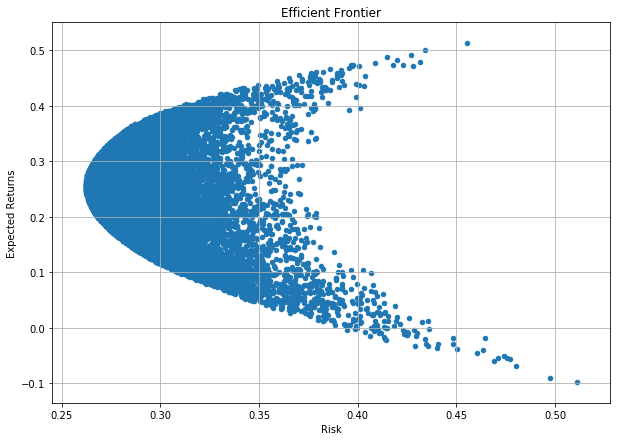

In [70]:
df.plot.scatter(x='Risk', y = 'Returns', figsize = (10,7), grid = True)
plt.title('Efficient Frontier')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

In [84]:
# 샤프 지수와 포트폴리오 최적화
# 샤프지수 = (포트폴리오 예상 수익률 - 무위험률)/수익률의 표준편차
# 여기선 무위험 수익률 = 0 이라고 가정

#포트폴리오 최적화 : 샤프지수를 이용해 위험 단위당 수익이 가장 높은 포트폴리오를 구하면
df['Sharpe'] = df['Returns']/df['Risk']
df

,Returns,Risk,삼성바이오로직스,SK하이닉스,카카오,NAVER,Sharpe
0,0.277216,0.273922,0.306293,0.209197,0.291700,0.192810,1.012027
1,0.243353,0.310597,0.415465,0.227809,0.032846,0.323880,0.783499
2,0.217275,0.288281,0.195728,0.564058,0.013117,0.227097,0.753692
3,0.242344,0.265731,0.203701,0.379269,0.219536,0.197494,0.911991
4,0.234177,0.306504,0.387148,0.202651,0.077014,0.333187,0.764027
...,...,...,...,...,...,...,...
19995,0.362134,0.291203,0.408737,0.304203,0.245804,0.041256,1.243579
19996,0.279168,0.294482,0.391007,0.124502,0.241615,0.242876,0.947997
19997,0.392806,0.315052,0.424857,0.050593,0.512766,0.011783,1.246796
19998,0.326564,0.276549,0.195698,0.381044,0.421263,0.001995,1.180853


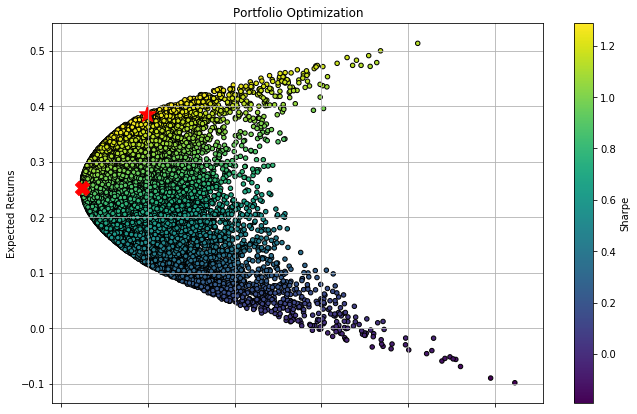

In [86]:
max_sharpe = df.loc[df['Sharpe'] == df['Sharpe'].max()]
min_risk = df.loc[df['Risk'] == df['Risk'].min()]

df.plot.scatter(x='Risk', y = 'Returns', c = 'Sharpe', cmap = 'viridis', edgecolors='k', figsize=(11,7), grid=True)
plt.scatter(x=max_sharpe['Risk'], y = max_sharpe['Returns'], c='r', marker='*', s=300)
plt.scatter(x=min_risk['Risk'], y = min_risk['Returns'], c = 'r', marker = 'X', s=200)
plt.title('Portfolio Optimization')
plt.xlabel('Risk')
plt.ylabel('Expected Returns')
plt.show()

In [88]:
max_sharpe # 리스크당 수익률이 가장 큰 포트폴리오

,Returns,Risk,삼성바이오로직스,SK하이닉스,카카오,NAVER,Sharpe
10767,0.386673,0.299857,0.414786,0.20501,0.37907,0.001134,1.289524


In [89]:
min_risk # 리스크가 가장 적은 포트폴리오

,Returns,Risk,삼성바이오로직스,SK하이닉스,카카오,NAVER,Sharpe
4802,0.253214,0.262191,0.164798,0.345234,0.333028,0.15694,0.965762


end_date is initialized to "2020-09-09"


C:\Users\1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51232 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 53581 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51232 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 53581 missing from current font.
  font.set_text

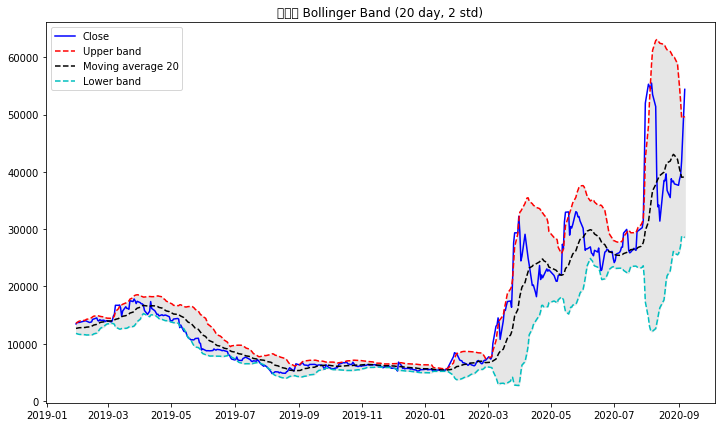

In [25]:
#볼린저밴드 지표
#볼린저밴드는 주가변동이 표준정규분포를 따른다는 가정에서 주가의 위아래에 밴드를 표시함으로서 주가의 상대저긴 높낮이를 알려줌

#볼린저밴드 구하기
#상단/하단 볼린저밴드 = 중간볼린저밴드 +- (2*표준편차), 중간볼린저밴드 = 20일평균

df = mk.get_daily_price('수젠텍', '2019-01-02')
df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df = df[19:] # df에서 19번째행까지는 NaN이므로 20번째행부터 사용

plt.figure(figsize=(12,7))
plt.plot(df.index, df['close'], color = '#0000ff', label = 'Close')
plt.plot(df.index, df['upper'], 'r--', label = 'Upper band')
plt.plot(df.index, df['MA20'], 'k--', label = 'Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label = 'Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
plt.legend(loc='best')
plt.title('Suzentec Bollinger Band (20 day, 2 std)')
plt.show()

end_date is initialized to "2020-09-09"


TypeError: 'bool' object is not callable

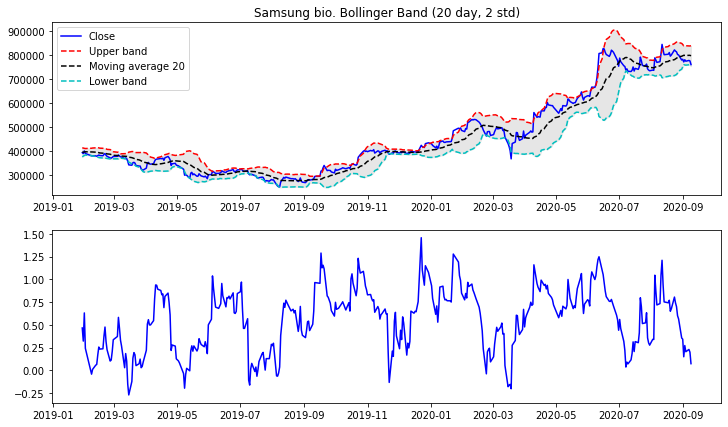

In [51]:
#볼린저밴드 지표 1 : %b
# %b는 종가가 볼린저 배드 어디에 위치하는지를 나타냄 만약 %b 가 1.1이면 upper band 의 10%위, %b = (종가 - 하단 볼린저밴드) / (상단 볼린저 밴드 - 중간 볼린저밴드)
df = mk.get_daily_price('삼성바이오로직스', '2019-01-02')
df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['close'] - df['lower'])/(df['upper']-df['lower'])
df = df[19:] # df에서 19번째행까지는 NaN이므로 20번째행부터 사용

plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.plot(df.index, df['close'], color = '#0000ff', label = 'Close')
plt.plot(df.index, df['upper'], 'r--', label = 'Upper band')
plt.plot(df.index, df['MA20'], 'k--', label = 'Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label = 'Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
plt.legend(loc='best')
plt.title('Samsung bio. Bollinger Band (20 day, 2 std)')

plt.subplot(2,1,2)
plt.plot(df.index, df['PB'], color='b',label='%b')
plt.grid(True) # plt.grid(True) 오류는 plt.grid = True를 처음에 잘못써서 생긴 오류
plt.legend(loc='best')
plt.show()

end_date is initialized to "2020-09-09"


TypeError: 'bool' object is not callable

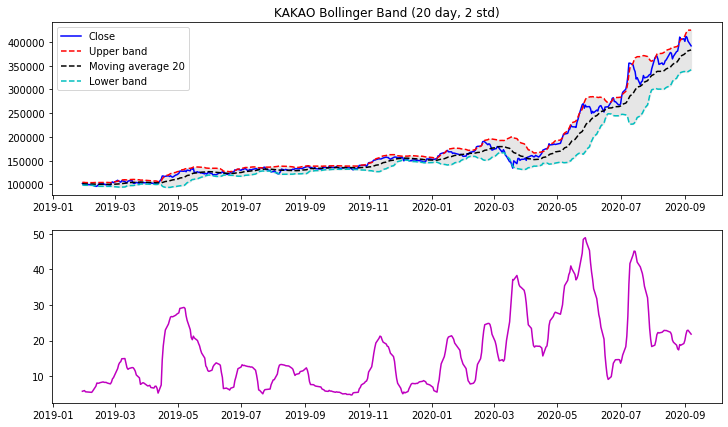

In [42]:
#볼린저밴드 지표 II : 밴드폭
#밴드폭은 상단 볼린저밴드와 하단 볼린저 밴드 사이의 폭, 스퀴즈(변동성이 극히 낮은 수준까지 떨어져 곧이어 변동성 증가가 발생할 것으로 예상되는 상황)을 확인하는 데 유용
#볼린저에 따르면 밴드폭이 6개월 저점을 기록하는 것을 보고 스퀴즈파악 가능
#밴드폭 = (상단볼린저밴드-하단볼린저밴드)/중간볼린저밴드
# 강력한 추세는 스퀴즈로부터 시작되는데 이때 추세 반대쪽에 있는 밴드는 추세 반대 방향으로 향함

df = mk.get_daily_price('카카오', '2019-01-02')
df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['bandwidth'] = (df['upper'] - df['lower'])/df['MA20'] *100
df = df[19:] # df에서 19번째행까지는 NaN이므로 20번째행부터 사용

plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.plot(df.index, df['close'], color = '#0000ff', label = 'Close')
plt.plot(df.index, df['upper'], 'r--', label = 'Upper band')
plt.plot(df.index, df['MA20'], 'k--', label = 'Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label = 'Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
plt.legend(loc='best')
plt.title('KAKAO Bollinger Band (20 day, 2 std)')

plt.subplot(2,1,2)
plt.plot(df.index, df['bandwidth'], color='m',label='Bandwidth')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [43]:
#볼린저 밴드 매매기법 - 단순히 상단밴드를 터치했을 때 매도하고, 하단 밴드를 터치했을 떄 매수하는게 X
#볼린저 밴드를 이용한 추세 추종 매매기법 ; 추세추종은 상승추세에서 매수, 하락추세에서 매도하는 기법 -> 현금흐름지표(MFI)나 일중강도(II) 거래량 관련 지표 필요
#매수 : %b > 0.8 & MFI >80
#매도 : %b < 0.2 & MFI <20

#MFI ; 중심가격 = (고가, 저가, 종가) / 3, 현금흐름 = 중심가격 * 거래량
# MFI = 100 - (100 / (1 + 긍정적 현금흐름/부정적 현금흐름)) ; 긍정적 현금흐름 : 중심가격이 전일보다 상슨한 날들의 현금흐름 합 , 부정적 현금흐름 : - 하락한 -

#10일 기준의 현금흐름지표를 구하려면
df['TP'] = (df['high'] + df['low'] + df['close'])/3
df['PMF'] = 0
df['NMF'] = 0
for i in range(len(df.close)-1): #0부터 종가의 개수 -2까지
    if df.TP.values[i] < df.TP.values[i+1]:
        df.PMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
        df.NMF.values[i+1] = 0
    else:
        df.NMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
        df.PMF.values[i+1] = 0
df['MFR'] = df.PMF.rolling(window=10).sum() / df.NMF.rolling(window=10).sum()
df['MFI10'] = 100 - 100 / (1+df['MFR'])
        

end_date is initialized to "2020-09-09"


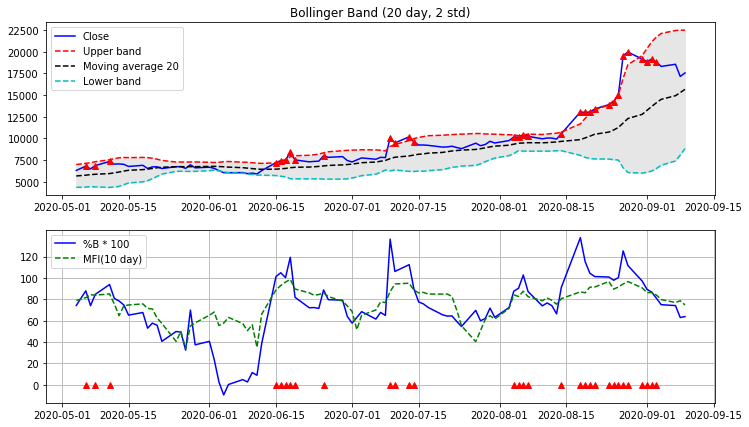

In [8]:
# 볼린저 추세추종 매매기법을 정리하면
import matplotlib.pyplot as plt
from Investar import Analyzer
%matplotlib inline

mk = Analyzer.MarketDB()
df = mk.get_daily_price('알서포트', '2020-04-02')

df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['close'] - df['lower'])/(df['upper']-df['lower'])
df['TP'] = (df['high'] + df['low'] + df['close'])/3
df['PMF'] = 0
df['NMF'] = 0

for i in range(len(df.close)-1): #0부터 종가의 개수 -2까지
    if df.TP.values[i] < df.TP.values[i+1]:
        df.PMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
        df.NMF.values[i+1] = 0
    else:
        df.NMF.values[i+1] = df.TP.values[i+1] * df.volume.values[i+1]
        df.PMF.values[i+1] = 0
df['MFR'] = df.PMF.rolling(window=10).sum() / df.NMF.rolling(window=10).sum()
df['MFI10'] = 100 - 100 / (1+df['MFR'])

df = df[19:]

plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.plot(df.index, df['close'], color = '#0000ff', label = 'Close')
plt.plot(df.index, df['upper'], 'r--', label = 'Upper band')
plt.plot(df.index, df['MA20'], 'k--', label = 'Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label = 'Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
plt.legend(loc='best')
plt.title('Bollinger Band (20 day, 2 std)')
for i in range(len(df.close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], df.close.values[i], 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], df.close.values[i], 'bv')

plt.subplot(2,1,2)
plt.plot(df.index, df['PB']*100, 'b', label = '%B * 100')
plt.plot(df.index, df['MFI10'], 'g--', label = 'MFI(10 day)')
plt.yticks([-20, 0 , 20, 40, 60, 80, 100, 120])
for i in range(len(df.close)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show()


end_date is initialized to "2020-09-09"


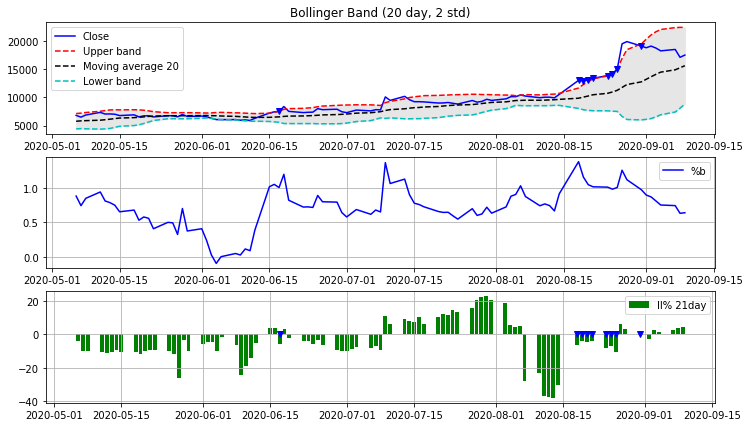

In [7]:
#볼린저 밴드를 이용한 반전매매기법 : 주가가 하단 밴드를 여러차례 태그하는 과정에서 강세지표가 발생하면 매수, 상단 밴드를 여러차례 태그하는 과정에서 약세지표가 발생하면 매도
#매수 : 주가가 하단 밴드 부근에서 W형 패턴을 나타내고 강세지표가 확증할 때(%b > 0.05 * II% >0)
#매도 : %b>0.95 & II% < 0

#일중강도(Intraday Intensity) : 장이 끝나는 시점에서 트레이더들의 움직임을 나타냄; 종가가 거래범위 천정권에서 형성되면 1, 중간에서 형성되면 0, 바닥권에서 형성되면 -1
# 21일 기간 동안의 II합을 21 기간동안의 거래량 합으로 나누어 표준화 한 것이 일중강도율 II%

#일중강도 = (2 x 종가 - 고가 - 저가 )/(고가 - 저가) * 거래량
#일중강도율 = 일중강도의 21일합/거래량의 21일합 * 100

import matplotlib.pyplot as plt
from Investar import Analyzer
%matplotlib inline

mk = Analyzer.MarketDB()
df = mk.get_daily_price('알서포트', '2020-04-02')

df['MA20'] = df['close'].rolling(window=20).mean()
df['stddev'] = df['close'].rolling(window=20).std()
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['close'] - df['lower'])/(df['upper']-df['lower'])

df['II'] = (2*df['close'] - df['high'] - df['low']) / (df['high'] - df['low']) * df['volume']
df['IIP21'] = df['II'].rolling(window=21).sum() / df['volume'].rolling(window=21).sum()*100
df = df.dropna()

plt.figure(figsize=(12,7))
plt.subplot(3,1,1)
plt.plot(df.index, df['close'], color = '#0000ff', label = 'Close')
plt.plot(df.index, df['upper'], 'r--', label = 'Upper band')
plt.plot(df.index, df['MA20'], 'k--', label = 'Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label = 'Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(0,len(df.close)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:
        plt.plot(df.index.values[i], df.close.values[i], 'r^')
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:
        plt.plot(df.index.values[i], df.close.values[i], 'bv')
plt.legend(loc='best')
plt.title('Bollinger Band (20 day, 2 std)')

plt.subplot(3,1,2)
plt.plot(df.index, df['PB'], 'b', label = '%b')
plt.grid(True)
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.bar(df.index, df['IIP21'], color = 'g', label = 'II% 21day')
for i in range(0,len(df.close)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show()

end_date is initialized to "2020-09-09"


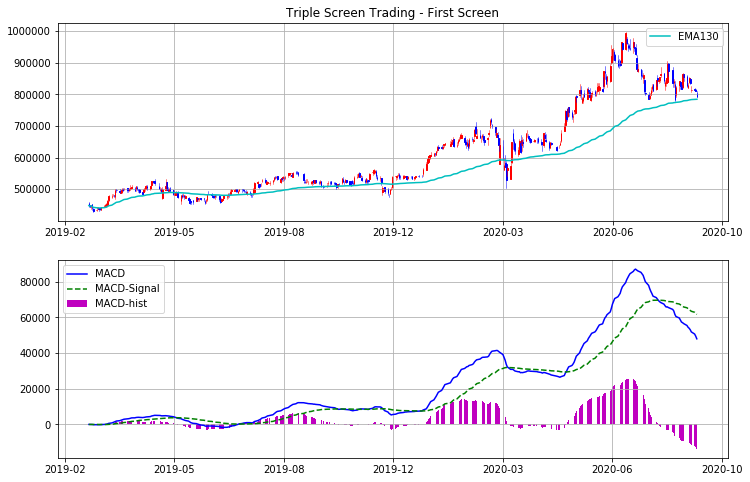

In [22]:
#심리투자법칙
#시장지표 (i) 추세지표 (ii) 오실레이터:상대적인 위치를 나타냄 (iii)기타지표
#여러 지표 설명은 생략

# 삼중창 매매 시스템 - 각 지표들의 단점을 서로 보완하도록 세 개의 창으로 설계
#첫번째 창- 시장조류 : 장기추세를 분석; 자신이 매매하는 단위보다 한단위 긴 단위의 차트를 이용해 분석

import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from Investar import Analyzer

mk = Analyzer.MarketDB()
df = mk.get_daily_price('엔씨소프트', '2019-03-03')

ema60 = df.close.ewm(span=60).mean() #종가의 12주 지수 이동평균
ema130 = df.close.ewm(span=130).mean() #종가의 26주 지수 이동 평균
macd = ema60 - ema130 #MACD선
signal = macd.ewm(span=45).mean() #신호선(MACD의 9주 이동평균) , 이러면 MACD의 속도 > signal의 속도로, MACD가 signal가 만날때 신호가 발생
macdhist = macd - signal #MACD 히스토그램

df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist).dropna()

df['number'] = df.index.map(mdates.date2num)
ohlc = df[['number', 'open', 'high','low','close']]

plt.figure(figsize=(12,8))
p1 = plt.subplot(2,1,1)
plt.title('Triple Screen Trading - First Screen')
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup = 'red', colordown = 'blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color = 'c', label = 'EMA130')
plt.legend(loc = 'best')

p2 = plt.subplot(2,1,2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.number, df['macdhist'], color='m', label ='MACD-hist')
plt.plot(df.number, df['macd'], color = 'b', label = 'MACD')
plt.plot(df.number, df['signal'], 'g--', label = 'MACD-Signal')
plt.legend(loc='best')
plt.show()

#결론적으로 말하면 EMA130 그래프가 오르고있을때만 시장에 참여

end_date is initialized to "2020-09-09"


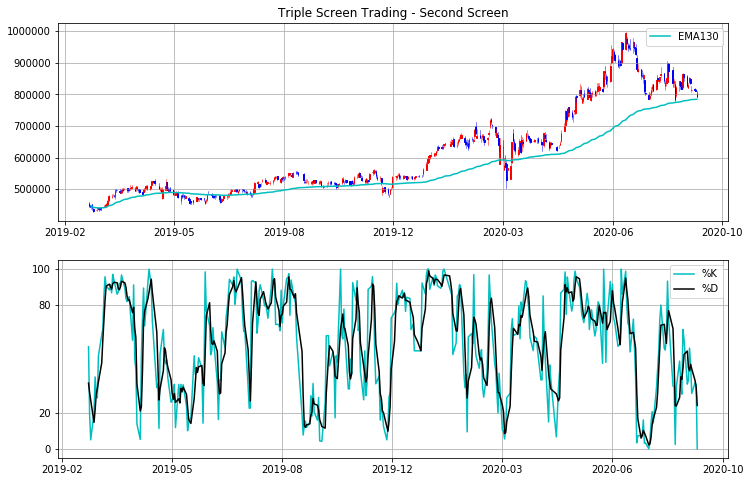

In [25]:
#두번째 창 - 시장파도를 파악하는 오실레이터 활용
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from Investar import Analyzer

mk = Analyzer.MarketDB()
df = mk.get_daily_price('엔씨소프트', '2019-03-03')

ema60 = df.close.ewm(span=60).mean() #종가의 12주 지수 이동평균
ema130 = df.close.ewm(span=130).mean() #종가의 26주 지수 이동 평균
macd = ema60 - ema130 #MACD선
signal = macd.ewm(span=45).mean() #신호선(MACD의 9주 이동평균) , 이러면 MACD의 속도 > signal의 속도로, MACD가 signal가 만날때 신호가 발생
macdhist = macd - signal #MACD 히스토그램

df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist).dropna()

df['number'] = df.index.map(mdates.date2num)
ohlc = df[['number', 'open', 'high','low','close']]

ndays_high = df.high.rolling(window=14, min_periods=1).max() #14일동안의 최대값; min_periods=1은 데이터가 1개만 있어도 최대값을 구하라는 의미
ndays_low = df.low.rolling(window=14, min_periods=1).min()
fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100 #% K선
slow_d = fast_k.rolling(window=3).mean()
df = df.assign(fast_k = fast_k, slow_d = slow_d).dropna()

plt.figure(figsize = (12,8))
p1 = plt.subplot(2,1,1)
plt.title("Triple Screen Trading - Second Screen")
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup = 'red', colordown = 'blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color = 'c', label = 'EMA130')
plt.legend(loc = 'best')

p1 = plt.subplot(2,1,2)
plt.grid(True)
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['fast_k'], color = 'c', label='%K')
plt.plot(df.number, df['slow_d'], color = 'k', label='%D')
plt.yticks([0,20,80,100])
plt.legend(loc='best')
plt.show()
# %D or %K 둘중 이용, 130일 지수이평선 상승 + 스토캐스틱이 30이하로 내려가면 매수기회, 130일 지수이평선이 하락 + 스토캐스틱이 70위로 올라가면 매도기회

end_date is initialized to "2020-09-09"


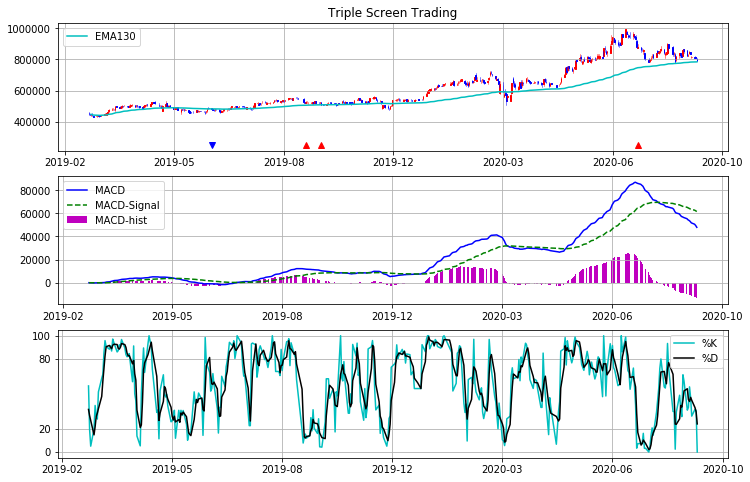

In [26]:
#세번째 창 - 진입기술
# 추적매수스톱 : 주간 추세가 상승하고 있을 때 일간 오실레이터가 하락하면서 매수신호가 발생하면 전일 고점보다 한 틱 위에 매수주문을 내는 것
#만약 추세대로 계속 상승해서 전일고점을 돌파하면 주문 체결

#주간 추세    오실레이터      행동      주문
# 상승          상승          관망        X
# 상승          하락           매수       추적매수스톱
#하락           하락            관망       X
#하락         상승               매도      추적매도스톱

#전체소스코드
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
from Investar import Analyzer

mk = Analyzer.MarketDB()
df = mk.get_daily_price('엔씨소프트', '2019-03-03')

ema60 = df.close.ewm(span=60).mean() #종가의 12주 지수 이동평균
ema130 = df.close.ewm(span=130).mean() #종가의 26주 지수 이동 평균
macd = ema60 - ema130 #MACD선
signal = macd.ewm(span=45).mean() #신호선(MACD의 9주 이동평균) , 이러면 MACD의 속도 > signal의 속도로, MACD가 signal가 만날때 신호가 발생
macdhist = macd - signal #MACD 히스토그램

df = df.assign(ema130=ema130, ema60=ema60, macd=macd, signal=signal, macdhist=macdhist).dropna()

df['number'] = df.index.map(mdates.date2num)
ohlc = df[['number', 'open', 'high','low','close']]

ndays_high = df.high.rolling(window=14, min_periods=1).max() #14일동안의 최대값; min_periods=1은 데이터가 1개만 있어도 최대값을 구하라는 의미
ndays_low = df.low.rolling(window=14, min_periods=1).min()
fast_k = (df.close - ndays_low) / (ndays_high - ndays_low) * 100 #% K선
slow_d = fast_k.rolling(window=3).mean()
df = df.assign(fast_k = fast_k, slow_d = slow_d).dropna()

plt.figure(figsize=(12,8))
p1 = plt.subplot(3,1,1)
plt.title('Triple Screen Trading')
plt.grid(True)
candlestick_ohlc(p1, ohlc.values, width=.6, colorup = 'red', colordown = 'blue')
p1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['ema130'], color = 'c', label = 'EMA130')
plt.legend(loc = 'best')
for i in range(1, len(df.close)):
    if df.ema130.values[i-1] < df.ema130.values[i] and df.slow_d.values[i-1] >=20 and df.slow_d.values[i] < 20:
        plt.plot(df.number.values[i], 250000, 'r^')
    elif df.ema130.values[i-1] > df.ema130.values[i] and df.slow_d.values[i-1] <=80 and df.slow_d.values[i] > 80:
        plt.plot(df.number.values[i], 250000, 'bv')

p2 = plt.subplot(3,1,2)
plt.grid(True)
p2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.bar(df.number, df['macdhist'], color='m', label ='MACD-hist')
plt.plot(df.number, df['macd'], color = 'b', label = 'MACD')
plt.plot(df.number, df['signal'], 'g--', label = 'MACD-Signal')
plt.legend(loc='best')

p3 = plt.subplot(3,1,3)
plt.grid(True)
p3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(df.number, df['fast_k'], color = 'c', label='%K')
plt.plot(df.number, df['slow_d'], color = 'k', label='%D')
plt.yticks([0,20,80,100])
plt.legend(loc='best')
plt.show()



In [7]:
#듀얼 모멘텀 투자
#모멘텀 - 주식이 같은 방향으로 움직이려는 성질; 군집행동, 정박효과, 확증편향, 처분효과 등으로 발생
# 듀얼 모멘텀 투자는 상대강도가 센 주식종목들에 투자하는 상대적 모멘텀 전략 + 과거 6~12개월의 수익의 단기 국채 수익률을 능가하는 강세장에서만 투자하는 절대적 모멘텀 전략을 하나로 합친 것

#듀얼모멘텀 클래스 구조

import pandas as pd
from Investar import Analyzer
from datetime import datetimem
import pymysql

class DualMomentum:
    def __init__(self):
        """생성자: KRX 종목코드(codes)를 구현하기 위한 marketDB객체 생성"""
        self.mk = Analyzer.MarketDB()
    
    def get_rltv_momentum(self, start_date, end_date, stock_count):
        """특정 기간 동안 수익률이 제일 높았는 stock_count 개의 종목들 구함(상대적 모멘텀)"""
        return df
    
    def get_abs_momentum(self, rltv_momentum, start_date, end_date):
        """특정 기간 동안 상대적 모멘텀에 투자했을 때의 평균 수익률 구함(절대적 모멘텀)"""
        return


ImportError: cannot import name 'datetimem' from 'datetime' (C:\Users\1\anaconda3\lib\datetime.py)

In [2]:
# 상대 모멘텀
def get_rltv_momentum(self, start_date, end_date, stock_count):
    #사용자로부터 시작일과 종료일을 입력받아 실제로 DB에서 조회되는 일자로 변경
    connection = pymysql.connect(host='localhost', port=3306, db='investar', user='root', password='qwe0611', autocommit=True)
    cursor = connection.cursor()
    
    sql = f"SELECT max(date) FROM daily_price where d <= '{start_date}'"
    cursor.execute(sql)
    result = cursor.fetchone()
    if (result[0] is None):
        print("start_date : {} -> returned None".format(sql))
        return
    start_date = result[0].strftime('%Y-%m-%d')
    
    sql = f"SELECT max(date) FROM daily_price where date <= '{end_date}'"
    cursor.execute(sql)
    result = cursor.fetchone()
    if (result[0] is None):
        print("end_date : {} -> returned None".format(sql))
        return
    end_date = result[0].strftime('%Y-%m-%d')
    
    #종목별 수익률 계산
    rows=[]
    columns=['code', 'company', 'old_price', 'new_price', 'returns']
    for _, code in enumerate(self.mk.codes):
        sql = f"select close from daily_price where code = '{code}' and date = '{start_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result is None):
            continue
        old_price = int(result[0])
        sql = f"select close from daily_price where code = '{code}' and date = '{end_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result is None):
            continue
        new_price = int(result[0])
        returns = (new_price/old_price -1) * 100
        rows.append([code, self.mk.codes[code], old_price, new_price, returns])
        
        df = pd.DateFrame(rows, columns=columns)
        df = df[['code', 'company','old_price','new_price','returns']]
        df = df.sort_values(by='returns',ascending = True)
        df = df.head(stock_count)
        df.index = pd.Index(range(stock_count))
        
        connection.close()
        print(df)
        print(f"\nRelative momentum ({start_date} ~ {end_date}) : {df['returns'].mean():.2f%}\n")
        return df

In [14]:
import pandas as pd
from Investar import Analyzer
from datetime import datetime
import pymysql

class DualMomentum:
    def __init__(self):
        """생성자: KRX 종목코드(codes)를 구현하기 위한 marketDB객체 생성"""
        self.mk = Analyzer.MarketDB()
    
    def get_rltv_momentum(self, start_date, end_date, stock_count):
        #사용자로부터 시작일과 종료일을 입력받아 실제로 DB에서 조회되는 일자로 변경
        connection = pymysql.connect(host='localhost', port=3306, db='investar', user='root', password='qwe0611', autocommit=True)
        cursor = connection.cursor()

        sql = f"SELECT max(date) FROM daily_price where date <= '{start_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print("start_date : {} -> returned None".format(sql))
            return
        start_date = result[0].strftime('%Y-%m-%d')

        sql = f"SELECT max(date) FROM daily_price where date <= '{end_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print("end_date : {} -> returned None".format(sql))
            return
        end_date = result[0].strftime('%Y-%m-%d')

        #종목별 수익률 계산
        rows=[]
        columns=['code', 'company', 'old_price', 'new_price', 'returns']
        for _, code in enumerate(self.mk.codes):
            sql = f"select close from daily_price where code = '{code}' and date = '{start_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            old_price = int(result[0])
            sql = f"select close from daily_price where code = '{code}' and date = '{end_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            new_price = int(result[0])
            returns = (new_price/old_price -1) * 100
            rows.append([code, self.mk.codes[code], old_price, new_price, returns])

        df = pd.DataFrame(rows, columns=columns)
        df = df[['code', 'company','old_price','new_price','returns']]
        df = df.sort_values(by='returns',ascending = False)
        df = df.head(stock_count)

        connection.close()
        print(df)
        print(f"\nRelative momentum ({start_date} ~ {end_date}) : {df['returns'].mean():.2f}%\n")
        return df
    
    def get_abs_momentum(self, rltv_momentum, start_date, end_date):
        """특정 기간 동안 상대적 모멘텀에 투자했을 때의 평균 수익률 구함(절대적 모멘텀)"""
        return


In [15]:
dm = DualMomentum()
rm = dm.get_rltv_momentum('2019-09-09','2020-09-08', 100)

       code    company  old_price  new_price      returns
146  019170       신풍제약       5980     140000  2241.137124
491  950130     엑세스바이오       2065      30350  1369.733656
341  096530         씨젠      20950     247000  1078.997613
418  205470       휴마시스       1480      13550   815.540541
472  285130      SK케미칼      43500     370500   751.724138
..      ...        ...        ...        ...          ...
263  060370     KT서브마린       3070       6270   104.234528
283  069080         웹젠      17850      36450   104.201681
136  016380     KG동부제철       6000      12200   103.333333
196  035420      NAVER     153000     311000   103.267974
427  214450  파마리서치프로덕트      33600      68100   102.678571

[100 rows x 5 columns]

Relative momentum (2019-09-09 ~ 2020-09-08) : 266.77%



In [8]:
#절대모멘텀까지 고려한 전체 소스코드
import pandas as pd
from Investar import Analyzer
from datetime import datetime
import pymysql

class DualMomentum:
    def __init__(self):
        """생성자: KRX 종목코드(codes)를 구현하기 위한 marketDB객체 생성"""
        self.mk = Analyzer.MarketDB()
    
    def get_rltv_momentum(self, start_date, end_date, stock_count):
        #사용자로부터 시작일과 종료일을 입력받아 실제로 DB에서 조회되는 일자로 변경
        connection = pymysql.connect(host='localhost', port=3306, db='investar', user='root', password='qwe0611', autocommit=True)
        cursor = connection.cursor()

        sql = f"SELECT max(date) FROM daily_price where date <= '{start_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print("start_date : {} -> returned None".format(sql))
            return
        start_date = result[0].strftime('%Y-%m-%d')

        sql = f"SELECT max(date) FROM daily_price where date <= '{end_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print("end_date : {} -> returned None".format(sql))
            return
        end_date = result[0].strftime('%Y-%m-%d')

        #종목별 수익률 계산
        rows=[]
        columns=['code', 'company', 'old_price', 'new_price', 'returns']
        for _, code in enumerate(self.mk.codes):
            sql = f"select close from daily_price where code = '{code}' and date = '{start_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            old_price = int(result[0])
            sql = f"select close from daily_price where code = '{code}' and date = '{end_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            new_price = int(result[0])
            returns = (new_price/old_price -1) * 100
            rows.append([code, self.mk.codes[code], old_price, new_price, returns])

        df = pd.DataFrame(rows, columns=columns)
        df = df[['code', 'company','old_price','new_price','returns']]
        df = df.sort_values(by='returns',ascending = False)
        df = df.head(stock_count)
        df.index = pd.Index(range(stock_count))

        connection.close()
        print(df)
        print(f"\nRelative momentum ({start_date} ~ {end_date}) : {df['returns'].mean():.2f}%\n")
        return df
    
    def get_abs_momentum(self, rltv_momentum, start_date, end_date):
        """특정 기간 동안 상대적 모멘텀에 투자했을 때의 평균 수익률 구함(절대적 모멘텀)"""
        stockList = list(rltv_momentum['code'])
        connection = pymysql.connect(host='localhost', port=3306, db='Investar', user = 'root', password = 'qwe0611', autocommit=True)
        cursor = connection.cursor()
        
        #입력한 날자를 DB 날짜로 변경
        sql = f"SELECT max(date) FROM daily_price where date <= '{start_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print("start_date : {} -> returned None".format(sql))
            return
        start_date = result[0].strftime('%Y-%m-%d')

        sql = f"SELECT max(date) FROM daily_price where date <= '{end_date}'"
        cursor.execute(sql)
        result = cursor.fetchone()
        if (result[0] is None):
            print("end_date : {} -> returned None".format(sql))
            return
        end_date = result[0].strftime('%Y-%m-%d')
        
        #상대모멘텀의 종목별 수익률을 구해서 2차원 리스트 형태로 추가
        rows=[]
        columns=['code', 'company', 'old_price', 'new_price', 'returns']
        for _, code in enumerate(stockList):
            sql = f"select close from daily_price where code = '{code}' and date = '{start_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            old_price = int(result[0])
            sql = f"select close from daily_price where code = '{code}' and date = '{end_date}'"
            cursor.execute(sql)
            result = cursor.fetchone()
            if (result is None):
                continue
            new_price = int(result[0])
            returns = (new_price/old_price -1) * 100
            rows.append([code, self.mk.codes[code], old_price, new_price, returns])
        
        #절대모멘텀 데이터프레임 생성 후 수익률 순으로 출력
        df = pd.DataFrame(rows, columns=columns)
        df = df[['code', 'company','old_price','new_price','returns']]
        df = df.sort_values(by='returns',ascending = False)
        connection.close()
        print(df)
        print(f"\nAbsolute momentum ({start_date} ~ {end_date}) : {df['returns'].mean():.2f}%")
        
        return

In [9]:
dm = DualMomentum()
rm = dm.get_rltv_momentum('2019-09-09', '2020-04-30', 5)

     code company  old_price  new_price     returns
0  084650   랩지노믹스       4425      25050  466.101695
1  096530      씨젠      20950      92900  343.436754
2  253840     수젠텍       6220      22900  268.167203
3  290650  엘앤씨바이오      21750      69800  220.919540
4  180640     한진칼      27900      87000  211.827957

Relative momentum (2019-09-09 ~ 2020-04-29) : 302.09%



In [10]:
am = dm.get_abs_momentum(rm, '2020-04-30', '2020-08-30')

     code company  old_price  new_price     returns
1  096530      씨젠      92900     246300  165.123789
3  290650  엘앤씨바이오      69800     136700   95.845272
2  253840     수젠텍      22900      37900   65.502183
0  084650   랩지노믹스      25050      40150   60.279441
4  180640     한진칼      87000      72800  -16.321839

Absolute momentum (2020-04-29 ~ 2020-08-28) : 74.09%
